In [1]:
from h5flow.data import dereference
import h5flow

import numpy as np

#f_name = '/global/cfs/cdirs/dune/users/demaross/MiniRun4_files_with_rock/MiniRun4_1E19_RHC.flow.00341.FLOW.proto_nd_flow.h5'
f_name = '/global/homes/d/demaross/ndlar_flow/scripts/proto_nd_scripts/MiniRun4_1E19_RHC.flow.00345.FLOW.proto_nd_flow.h5'
f = h5flow.data.H5FlowDataManager(f_name, 'r')

In [2]:
#Rock muon tracks to their hits

track2hits = dereference(
    f['/analysis/rock_muon_tracks/data']['rock_muon_id'],     # indices of A to load references for, shape: (n,)
    f['/analysis/rock_muon_tracks/ref/charge/calib_prompt_hits/ref'],  # references to use, shape: (L,)
    f['/charge/calib_final_hits/data'],
    ref_direction = (0,1)# dataset to load, shape: (M,)
    )

# Rock muon segments to their track

segment2hits = dereference(
    f['/analysis/rock_muon_segments/data']['rock_segment_id'],
    f['/analysis/rock_muon_segments/ref/charge/calib_prompt_hits/ref'],
    f['/charge/calib_final_hits/data'],
    ref_direction = (0,1)
    )

track2segment = dereference(
    slice(0,f['analysis/rock_muon_tracks/data']['rock_muon_id'].max()+1),
    f['/analysis/rock_muon_tracks/ref/analysis/rock_muon_segments/ref'],
    f['/analysis/rock_muon_segments/data'],
    ref_direction = (0,1)
)
    

In [3]:

import numpy as np

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import mplhep as hep

from h5flow.data import dereference
import h5flow

'''

Let's plot the first rock muon segments within this data file

'''
#Detector boundaries for MR5, for MR4 just minus 268 from y_boundaries and add 1300 to z_boundaries

x_boundaries = np.array([-63.931, -3.069, 3.069, 63.931])
y_boundaries = np.array([-42-19.8543, -42+103.8543]) - 268
z_boundaries = np.array([-64.3163,  -2.6837, 2.6837, 64.3163]) + 1300 


#Plotting functions
def draw_cathode_planes(x_boundaries, y_boundaries, z_boundaries, **kwargs):
    
    traces = []
    for i_z in range(int(len(z_boundaries)/2)):
        for i_x in range(int(len(x_boundaries)/2)):
            z, y = np.meshgrid(np.linspace(z_boundaries[i_z * 2], z_boundaries[i_z * 2 + 1], 2), np.linspace(y_boundaries.min(), y_boundaries.max(),2))
            x = (x_boundaries[i_x * 2] + x_boundaries[i_x * 2 + 1]) * 0.5 * np.ones(z.shape)

            traces.append(go.Surface(x=x, y=y, z=z, **kwargs))
    return traces

def draw_anode_planes(x_boundaries, y_boundaries, z_boundaries, **kwargs):
    
    traces = []
    for i_z in range(int(len(z_boundaries)/2)):
        for i_x in range(int(len(x_boundaries))):           
            z, y = np.meshgrid(np.linspace(z_boundaries[i_z * 2], z_boundaries[i_z * 2 + 1], 2), np.linspace(y_boundaries.min(), y_boundaries.max(),2))
            x = x_boundaries[i_x] * np.ones(z.shape)

            traces.append(go.Surface(x=x, y=y, z=z, **kwargs))
    return traces

def plot_segs(segs, **kwargs):
    
    def to_list(axis):
        return np.column_stack([
            segs[f'{axis}_start'],
            segs[f'{axis}_end'],
            np.full(len(segs), None)
        ]).flatten().tolist()
        
    x, y, z = (to_list(axis) for axis in 'xyz')

    trace = go.Scatter3d(x=x, y=y, z=z, **kwargs)
    
    return trace

def vtx_in_LArActive(vtx, x_boundaries, y_boundaries, z_boundaries):
    vtx_in_Active = False
    if vtx[0] >= np.min(x_boundaries) and vtx[0] <= np.max(x_boundaries):
        if vtx[1] >= np.min(y_boundaries) and vtx[1] <= np.max(y_boundaries):
            if vtx[2] >= np.min(z_boundaries) and vtx[2] <= np.max(z_boundaries):
                vtx_in_Active = True
    
    return vtx_in_Active

# Referencing from segments to hits of the segments

In [24]:
segments_of_track = track2segment.data[0]
segments_of_track = np.array([tup for tup in segments_of_track if not all(elem == 0 for elem in tup)], dtype = segments_of_track.dtype)


hits_for_segments = []

for i in range(len(segments_of_track)):
    hits_of_segments = segment2hits[segments_of_track[i]['rock_segment_id']].data
    hits_for_segments.append(np.array([tup for tup in hits_of_segments if not all(elem == 0 for elem in tup)], dtype = hits_of_segments.dtype))


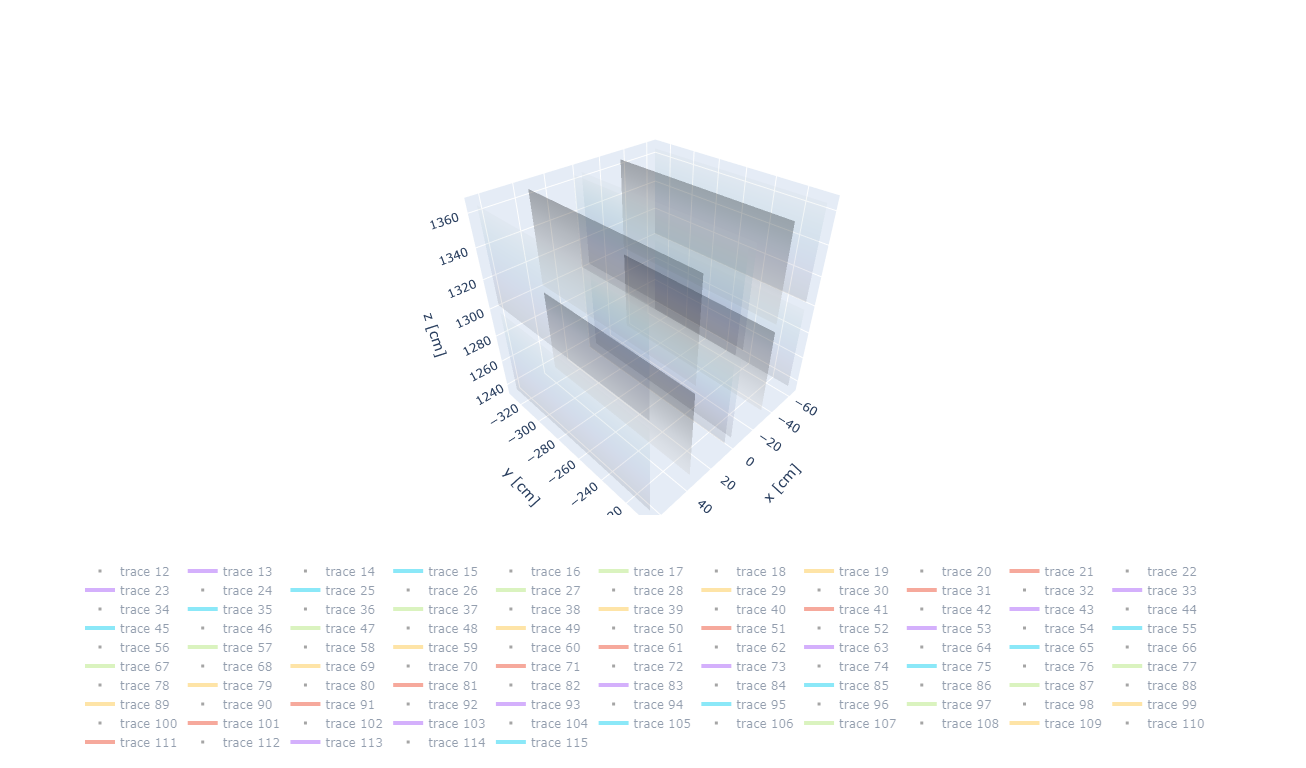

In [25]:
fig = go.Figure()

plot_outActive_vertices = False


##########################
# Draw the cathodes
##########################
fig.add_traces(draw_cathode_planes(
    x_boundaries, y_boundaries, z_boundaries, 
    showscale=False,
    opacity=0.3,
    colorscale='Greys',
))

##########################
# Draw the anodes
##########################
fig.add_traces(draw_anode_planes(
    x_boundaries, y_boundaries, z_boundaries, 
    showscale=False,
    opacity=0.1,
    colorscale='ice',
))

for i in range(len(segments_of_track)):
    rock_muon_hits = hits_for_segments[i]
    seg = segments_of_track[i]
    
        # Draw the prompt hits
    ##########################
    PHits_traces = go.Scatter3d(
            x= rock_muon_hits['x'].flatten(), y= rock_muon_hits['y'].flatten(), z= rock_muon_hits['z'].flatten(),
            marker_color= rock_muon_hits['id'],
            mode='markers',
            marker_size=3,
            marker_symbol='square',
            visible='legendonly',
            showlegend=True,
            opacity=0.7,)
    fig.add_traces(PHits_traces)
    
    line_data = go.Scatter3d(
    x=[seg['x_start'], seg['x_end']],
    y=[seg['y_start'], seg['y_end']],
    z=[seg['z_start'], seg['z_end']],
    mode='lines',
    visible='legendonly',
    showlegend=True,
    line=dict(color=seg['rock_segment_id'], width=4)
    )
    fig.add_traces(line_data)

fig.update_layout(
    width=1024, height=768,
    legend_orientation="h",
    scene = dict(xaxis_title='x [cm]',
                yaxis_title='y [cm]',
                zaxis_title='z [cm]')    
)

fig.show()

# Plotting a rock muon track

In [35]:
#index is the ith track, which is also the ith indx in the f['analysis/rock_muon_tracks/data']
track_to_hits = track2hits.data[0]
rock_muon_hits = np.array([tup for tup in track_to_hits if not all(elem == 0 for elem in tup)], dtype = track_to_hits.dtype)


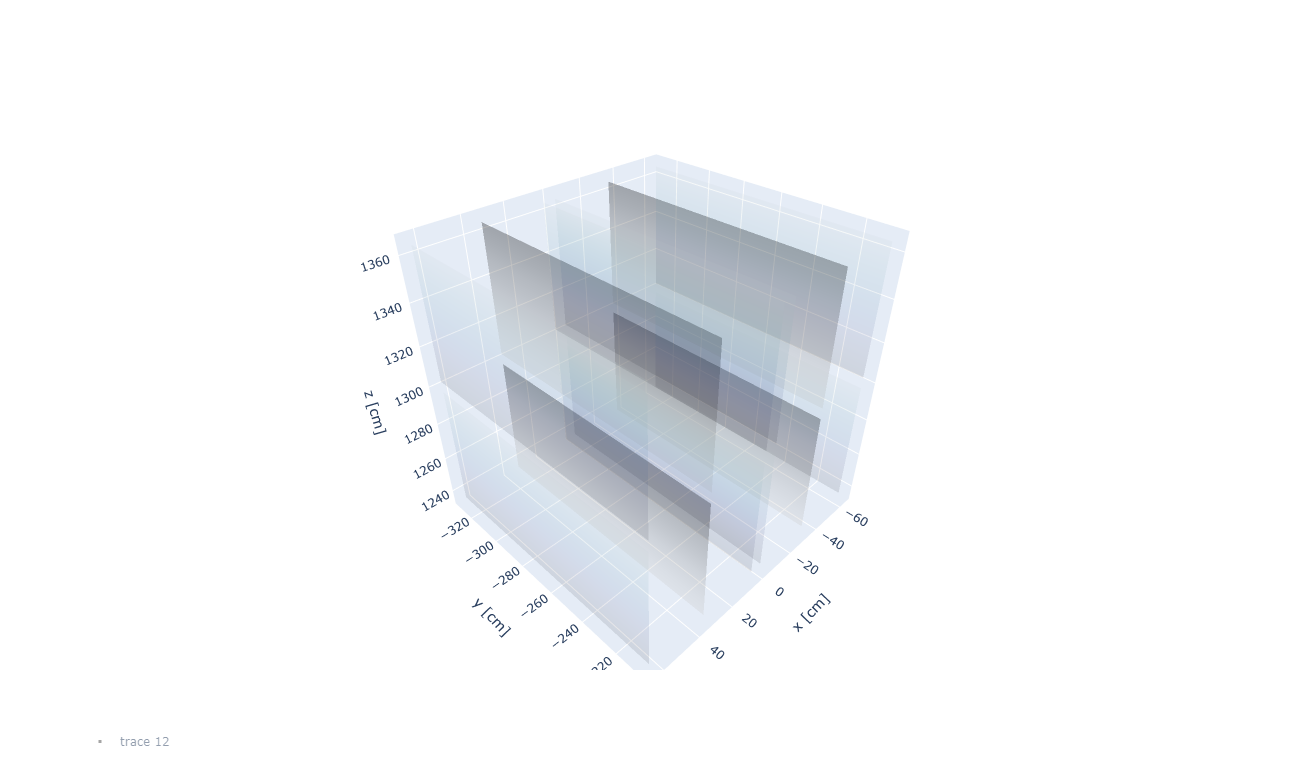

In [36]:
fig = go.Figure()

plot_outActive_vertices = False


##########################
# Draw the cathodes
##########################
fig.add_traces(draw_cathode_planes(
    x_boundaries, y_boundaries, z_boundaries, 
    showscale=False,
    opacity=0.3,
    colorscale='Greys',
))

##########################
# Draw the anodes
##########################
fig.add_traces(draw_anode_planes(
    x_boundaries, y_boundaries, z_boundaries, 
    showscale=False,
    opacity=0.1,
    colorscale='ice',
))

    # Draw the prompt hits
##########################
PHits_traces = go.Scatter3d(
        x= rock_muon_hits['x'].flatten(), y= rock_muon_hits['y'].flatten(), z= rock_muon_hits['z'].flatten(),
        marker_color= rock_muon_hits['id'],
        mode='markers',
        marker_size=3,
        marker_symbol='square',
        visible='legendonly',
        showlegend=True,
        opacity=0.7,)
fig.add_traces(PHits_traces)

fig.update_layout(
    width=1024, height=768,
    legend_orientation="h",
    scene = dict(xaxis_title='x [cm]',
                yaxis_title='y [cm]',
                zaxis_title='z [cm]')    
)

fig.show()
